## In this project, we are going to classify lung problem of patients having Pneumonia or Normal. The method we will apply is Bayesian Convolution Neural Network with a customized loss function.

+ Pneumonia is an infection that inflames your lungs' air sacs (alveoli). The air sacs may fill up with fluid or pus, causing symptoms such as a cough, fever, chills and trouble breathing. The Xray of the lung can tell us if the lung is normal or not normal. The normal Xray will be like a clear picture of the ribs while the abnormal looks like there are some large white areas. 
+ The goal is to teach machine to recognize which image is not normal and which one is normal. The dataset I used is from Kaggle with the link https://www.kaggle.com/pcbreviglieri/pneumonia-xray-images

In [2]:
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
train_DATADIR = "C:\\Users\\phill\\Documents\\Studies and Research\Computer vision meets medical history and genomics\\chest_xray\\train"
val_DATADIR = "C:\\Users\\phill\\Documents\\Studies and Research\Computer vision meets medical history and genomics\\chest_xray\\val"
test_DATADIR = "C:\\Users\\phill\\Documents\\Studies and Research\Computer vision meets medical history and genomics\\chest_xray\\test"

In [3]:
image_size = (250, 250)
batch_size = 24

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_DATADIR,
    subset="training",
    seed=1337,
    validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode = "categorical",
    shuffle=True,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_DATADIR,
    subset="validation",
    seed=1337,
    validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode = "categorical",
    shuffle=True,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_DATADIR,
    seed=1337,
    # subset="training",
    # validation_split=0.2,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode = "categorical",
    shuffle=True,
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


C:\Users\phill\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
lung_images = val_ds.take(1)

    

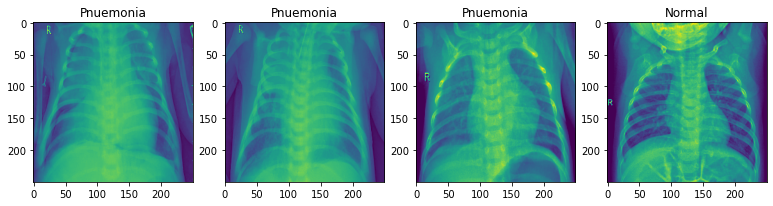

In [5]:
lung_class = [ "Pnuemonia","Normal"]

for img, label in lung_images:
    plt.figure(figsize=(20, 30))
    for i in range(4):
        ax = plt.subplot(4, 6, i+1)
        # print(img[i].numpy().reshape(250,250))
        plt.imshow(img[i].numpy())
        plt.title(lung_class[label[i].numpy().astype("uint8")[0]])
        # print(label[i].numpy()[0])

We apply Bayesian CNN with Monte Carlo (MC) dropout technique. In order to do it, we apply Keras Functional API.

In [6]:
train_len = 5216
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / train_len
def custom_loss(layer):
    kl = tf.keras.losses.KLDivergence(
    reduction=tf.keras.losses.Reduction.SUM)
    cce = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.SUM)
    


    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return kl(y_true,y_pred) + cce(y_true,y_pred)  + tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        # return  kl(y_true,y_pred) + cce(y_true,y_pred) + tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
   
    # Return a function
    return loss

lung_input = tf.keras.Input(shape=(250,250,1))
x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)(lung_input)
x= tfp.layers.Convolution2DFlipout(64,kernel_size=(3,3),padding="same", activation = 'relu', input_shape=(250,250,1))(x)
# x = tf.keras.layers.Conv2D(64, kernel_size=(2,2), padding="same", activation="relu", input_shape = (250,250,1))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(24, kernel_size=(2,2), padding="same", activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x, training = True)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(40, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(12, activation="relu")(x)
lung_ouput = tfp.layers.DenseFlipout(2, activation="softmax")(x)

model_bnn = keras.Model(lung_input, lung_ouput, name = "lungBNN")
model_bnn.compile(loss=custom_loss(layers), optimizer="adam", metrics=['accuracy', "AUC"])
model_bnn.summary()






C:\Users\phill\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "lungBNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 250, 250, 1)       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 250, 250, 64)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 64)      256       
_________________________________________________________________
conv2d (Conv2D)              (None, 250, 250, 24)      6168      
_________________________________________________________________
dropout (Dropout)            (None, 250, 250, 24)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 24)      0   

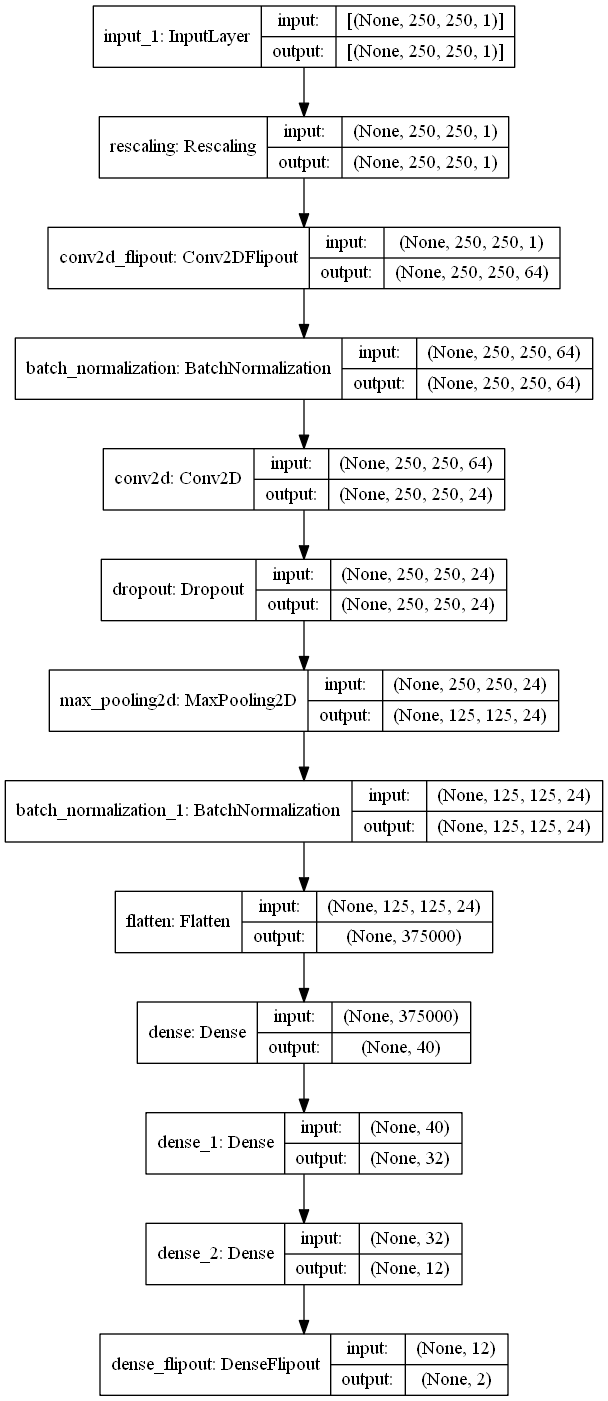

In [7]:
tf.keras.utils.plot_model(model_bnn, show_shapes=True)

We will use early stop feature during training and choose the one with best val_accuracy.

In [8]:
from keras import backend as K
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# K.set_value(model_vi.optimizer.learning_rate, 0.05)
bnn = model_bnn.fit(train_ds,epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
174/174 [==============================] - 70s 366ms/step - loss: 1617.5850 - accuracy: 0.6883 - auc: 0.7491 - val_loss: 1593.1826 - val_accuracy: 0.7411 - val_auc: 0.7647
Epoch 2/10
174/174 [==============================] - 60s 340ms/step - loss: 1474.6132 - accuracy: 0.8982 - auc: 0.9608 - val_loss: 1433.3336 - val_accuracy: 0.9041 - val_auc: 0.9633
Epoch 3/10
174/174 [==============================] - 60s 340ms/step - loss: 1412.5806 - accuracy: 0.9517 - auc: 0.9882 - val_loss: 1371.6027 - val_accuracy: 0.9319 - val_auc: 0.9756
Epoch 4/10
174/174 [==============================] - 60s 343ms/step - loss: 1351.9712 - accuracy: 0.9457 - auc: 0.9854 - val_loss: 1307.5924 - val_accuracy: 0.9319 - val_auc: 0.9717
Epoch 5/10
174/174 [==============================] - 60s 340ms/step - loss: 1286.0408 - accuracy: 0.9530 - auc: 0.9885 - val_loss: 1247.1943 - val_accuracy: 0.9041 - val_auc: 0.9569
Epoch 6/10
174/174 [==============================] - 60s 340ms/step - loss: 1218.358

In [9]:
model_bnn.evaluate(test_ds)

26/26 [==============================] - 4s 141ms/step - loss: 976.2714 - accuracy: 0.6891 - auc: 0.7849


[976.2714233398438, 0.6891025900840759, 0.7848865985870361]

Now, we would like to show you how Bayesian prediction looks like. It is different from the normal prediction.

In [10]:
example_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_DATADIR,
    seed=1337,
    # subset="training",
    # validation_split=0.2,
    image_size=image_size,
    batch_size=1,
    color_mode='grayscale',
    label_mode = "categorical",
    shuffle=True,
)

Found 624 files belonging to 2 classes.


In [11]:

pred_image, pred_label = list(example_ds.take(1))[0]


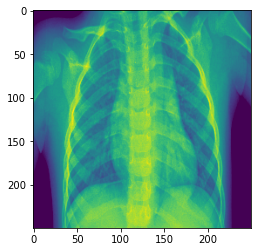

In [12]:
plt.imshow(pred_image[0])

To make a prediction for any input, we need to run the model prediction many times to see how the distribution of the results look like. Notice that, Bayesian statistics results are based on a distribution. To see how the distribution looks like in order to make the prediction, we need to have enough samples from that distribution. That is the reason we must run the prediction many times (I chose 100 times in this case)

In [13]:
pred_results = []
for i in range(100):
    test = model_bnn.predict(pred_image)
    pred_results.append([test[0][0],test[0][1]])

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  2.,  3.,  2., 90.]),
 array([0.08454249, 0.17608824, 0.267634  , 0.35917974, 0.4507255 ,
        0.54227126, 0.633817  , 0.7253627 , 0.8169085 , 0.90845424,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

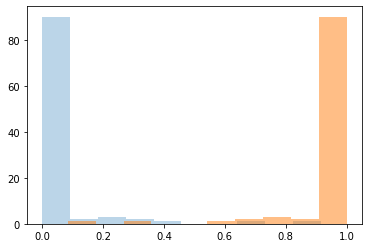

In [14]:
plt.hist(np.array(pred_results)[0:100,0], alpha = 0.3)
plt.hist(np.array(pred_results)[0:100,1], alpha = 0.5)

Our model predicts that the patient with the pred_image above had pneumonia. We can see that from the histograms, the probability of getting normal is almost 0 and getting pneumonia is almost 1. However, there is some uncertainty about the conclusion. There is some concerns about the decision but the probability of having the concern is too smalll comparing to the probability of making the final decision.

Text(0.5, 1.0, 'Pnuemonia')

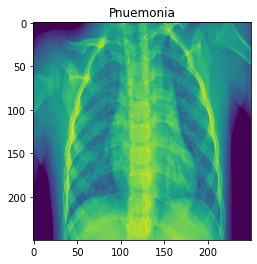

In [15]:
plt.imshow(pred_image[0])
plt.title(lung_class[np.argmax(pred_label[0].numpy())])

We can see that, the prediction is correct in this situation. Moreover, the histograms told us that the probability of getting the wrong prediction is very thin, almost 0 in this case. This is one of the major differences between Bayesian uncertainty neuron network vs. non-Bayesian neural network in deep learning.